# 11.1 Sparse coding (Olshausen & Field, 1996) モデル

## 11.1.1 Sparse codingと生成モデル
Sparse codingモデル([Olshausen & Field, *Nature*. 1996](https://www.nature.com/articles/381607a0))はV1のニューロンの応答特性を説明する**線形生成モデル** (linear generative model)である。まず、画像パッチ $\boldsymbol{I} (\boldsymbol{x})$が基底関数(basis function)あるいは特徴量(features) $\Phi = [\phi_i(\boldsymbol{x})]$ のノイズを含む線形和で表されるとする (係数は$\boldsymbol{r}=[r_i]$とする)。

$$
\boldsymbol{I}(\boldsymbol{x}) = \sum_i r_i \phi_i (\boldsymbol{x}) + \epsilon(\boldsymbol{x})= \Phi \boldsymbol{r} + \boldsymbol{\epsilon}(\boldsymbol{x})\quad \tag{1}
$$

ただし、$\boldsymbol{x}$は画像上の座標, $\epsilon$は平均0, 分散$\sigma^2$のGaussianノイズを表す (各ノイズは独立とする)。このモデルを神経ネットワークのモデルと考えると、$\Phi$は重み行列、係数$\boldsymbol{r}$は入力よりも高次の神経細胞の活動度を表していると解釈できる。ただし、$r_i$は負の値も取るので単純に発火率と捉えられないのはこのモデルの欠点である。

Sparse codingでは神経活動$\boldsymbol{r}$が潜在変数の推定量を表現しているという仮定の下、少数の基底で画像 (や目的変数)を表すことを目的とする。要は上式において、ほとんどが0で、一部だけ0以外の値を取るという疎 (=sparse)な係数$\boldsymbol{r}$を求めたい。

### 確率的モデルの記述
````{margin}
```{note}
以後の記述は([Olshausen & Field, 1997](https://pubmed.ncbi.nlm.nih.gov/9425546/))に従ったものである。
```
````

入力される画像パッチの真の分布を$q(\boldsymbol{I})$, 生成モデルの分布を$p(\boldsymbol{I}|\Phi)$とする。さらに潜在変数 $\boldsymbol{r}$の事前分布 (prior)を$p(\boldsymbol{r})$, 画像パッチ $\boldsymbol{I}$の尤度 (likelihood)を$p(\boldsymbol{I}|\boldsymbol{r}, \Phi)$とする。このとき、

$$
p(\boldsymbol{I}|\Phi)=\int p(\boldsymbol{I}|\boldsymbol{r}, \Phi)p(\boldsymbol{r})d\boldsymbol{r} \quad \tag{2}
$$

が成り立つ。$p(\boldsymbol{I}|\boldsymbol{r}, \Phi)$は、(1)式においてノイズ項を$\epsilon_j \sim\mathcal{N}(0, \sigma^2)$としたことから、

$$
\begin{align}
p(\boldsymbol{I}|\ \boldsymbol{r}, \Phi)&=\mathcal{N}\left(\boldsymbol{I}|\ \Phi \boldsymbol{r}, \sigma^2 \right)\\
&=\frac{1}{Z_{\sigma}} \exp\left(-\frac{\|\boldsymbol{I} - \Phi \boldsymbol{r})\|^2}{2\sigma^2}\right)\quad \tag{3}
\end{align}
$$

と表せる。ただし、$Z_{\sigma}$は規格化定数である。

### 事前分布の設定
事前分布$p(\boldsymbol{r})$としては、0においてピークがあり、裾の重い(heavy tail)を持つsparse distributionあるいは **super-Gaussian distribution** (Laplace 分布やCauchy分布などGaussian分布よりもkurtoticな分布)を用いるのが良い。このような分布では、$\boldsymbol{r}$の各要素$r_i$はほとんど0に等しく、ある入力に対しては大きな値を取る。$p(\boldsymbol{r})$は一般化して式(4), (5)のように表記する。

$$
\begin{align}
p(\boldsymbol{r})&=\prod_i p(r_i) \quad \tag{4}\\
p(r_i)&=\frac{1}{Z_{\beta}}\exp \left[-\beta S(r_i)\right] \quad \tag{5}
\end{align}
$$

ただし、$\beta$は逆温度(inverse temperature), $Z_{\beta}$は規格化定数 (分配関数) である[^can]。$S(x)$と分布の関係をまとめた表が以下となる (cf. [Harpur, 1997](https://pdfs.semanticscholar.org/be08/da912362bf40fe3ded78bdadc644f921b4e7.pdf))。

[^can]: これらの用語は統計力学における正準分布 (ボルツマン分布)から来ている。

|$S(r)$|$\dfrac{dS(r)}{dr}$|$p(r)$|分布名|尖度(kurtosis)|
|:-:|:-:|:-:|:-:|:-:|
|$r^2$|$2r$|$\dfrac{1}{\alpha \sqrt{2\pi}}\exp\left(-\dfrac{r^2}{2\alpha^2}\right)$|Gaussian 分布|0|
|$\vert r\vert$|$\text{sign}(r)$|$\dfrac{1}{2\alpha}\exp\left(-\dfrac{\vert r\vert}{\alpha}\right)$|Laplace 分布|3.0|
|$\ln (\alpha^2+r^2)$|$\dfrac{2r}{\alpha^2+r^2}$|$\dfrac{\alpha}{\pi}\dfrac{1}{\alpha^2+r^2}=\dfrac{\alpha}{\pi}\exp[-\ln (\alpha^2+r^2)]$|Cauchy 分布|-|

分布$p(r)$や$S(r)$を描画すると次のようになる。

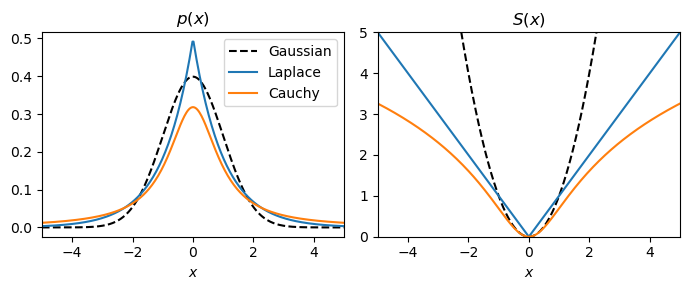

In [1]:
using PyPlot

x = range(-5, 5, length=300)
figure(figsize=(7,3))
subplot(1,2,1)
title(L"$p(x)$")
plot(x, 1/sqrt(2pi)*exp.(-(x.^2)/2), color="black", linestyle="--",label="Gaussian")
plot(x, 1/2*exp.(-abs.(x)), label="Laplace")
plot(x, 1 ./ (pi*(1 .+ x.^2)), label="Cauchy")
xlim(-5, 5); 
xlabel(L"$x$")
legend()

subplot(1,2,2)
title(L"S(x)")
plot(x, x.^2, color="black", linestyle="--",label="Gaussian")
plot(x, abs.(x), label="Laplace")
plot(x, log.(1 .+ x.^2), label="Cauchy")
xlim(-5, 5); ylim(0, 5)
xlabel(L"$x$")

tight_layout()

## 11.1.2 MAP推定と目的関数の設定
最適な生成モデルを得るために、入力される画像パッチの真の分布 $q(\boldsymbol{I})$と生成モデルの分布 $p(\boldsymbol{I}|\Phi)$を近づける。すなわち、2つの分布のKullback-Leibler ダイバージェンス $D_{\text{KL}}\left(q(\boldsymbol{I}) \Vert\ p(\boldsymbol{I}|\Phi)\right)$を最小化する。ただし、

$$
\begin{align}
D_{\text{KL}}(q(\boldsymbol{I}) \| p(\boldsymbol{I}|\Phi))&=\int q(\boldsymbol{I}) \log \frac{q(\boldsymbol{I})}{p(\boldsymbol{I}|\Phi)} d\boldsymbol{I}\\
&=\mathbb{E}_q \left[\ln \frac{q(\boldsymbol{I})}{p(\boldsymbol{I}|\Phi)}\right]\\
&=\mathbb{E}_q \left[\ln q(\boldsymbol{I})\right]-\mathbb{E}_q \left[\ln p(\boldsymbol{I}|\Phi)\right] \tag{6}
\end{align}
$$

が成り立つ。(6)式の1番目の項は一定なので、$D_{\text{KL}}$を最小化するには$\mathbb{E}_q \left[\ln p(\boldsymbol{I}|\Phi)\right]$を最大化すればよい。ここで、(2)式より、

$$
\mathbb{E}_q \left[\ln p(\boldsymbol{I}|\Phi)\right]=\mathbb{E}_q \left[\ln \int p(\boldsymbol{I}|\boldsymbol{r}, \Phi)p(\boldsymbol{r})d\boldsymbol{r}\right]\tag{7}
$$

が成り立つ。ここで近似として $\int p(\boldsymbol{I}|\boldsymbol{r}, \Phi)p(\boldsymbol{r})d\boldsymbol{r}$ を $p(\boldsymbol{I}|\boldsymbol{r}, \Phi)p(\boldsymbol{r}) \left(=p(\boldsymbol{I}, \boldsymbol{r}| \Phi)\right)$ の最大値で評価することにする。この近似の下、最適な$\Phi=\Phi^*$は次のようにして求められる。

$$
\begin{align}
\Phi^*&=\text{arg} \min_{\Phi} \min_{\boldsymbol{r}} D_{\text{KL}}(q(\boldsymbol{I}) \| p(\boldsymbol{I}|\Phi))\\
&=\text{arg} \max_{\Phi} \max_{\boldsymbol{r}} \mathbb{E}_q \left[\ln p(\boldsymbol{I}|\Phi)\right]\\
&\approx \text{arg} \max_{\Phi}\max_{\boldsymbol{r}} \ln p(\boldsymbol{I}|\boldsymbol{r}, \Phi)p(\boldsymbol{r})\\
&=\text{arg}\min_{\Phi} \min_{\boldsymbol{r}}\ E(\boldsymbol{I}, \boldsymbol{r}|\Phi)\tag{8}
\end{align}
$$

ただし、$E(\boldsymbol{I}, \boldsymbol{r}|\Phi)$はコスト関数であり、次式のように表される。

$$
\begin{align}
E(\boldsymbol{I}, \boldsymbol{r}|\Phi):=&-\ln p(\boldsymbol{I}|\boldsymbol{r}, \Phi)p(\boldsymbol{r})\\
=&\underbrace{\left\|\boldsymbol{I}-\Phi \boldsymbol{r}\right\|^2}_{\text{preserve information}} + \lambda \underbrace{\sum_i S\left(r_i\right)}_{\text{sparseness of}\ r_i}\tag{9}
\end{align}
$$

ただし、$\lambda=2\sigma^2\beta$は正則化係数[^lam]であり、1行目から2行目へは式(3), (4), (5)を用いた。ここで、第1項が復元損失、第2項が罰則項 (正則化項)となっている。勾配法により、$E(\boldsymbol{I}, \boldsymbol{r}|\Phi)$を最小化する。これには$\Phi$を固定した下で$E(\boldsymbol{I}, \boldsymbol{r}|\Phi)$を最小化する$\boldsymbol{r}=\hat{\boldsymbol{r}}$を求める ([11.1.3](#locally-competitive-algorithm-lca))。

$$
\hat{\boldsymbol{r}}=\text{arg}\min_{\boldsymbol{r}}E(\boldsymbol{I}, \boldsymbol{r}|\Phi)
$$

次に$\hat{\boldsymbol{r}}$を用いて

$$
\Phi^*=\text{arg}\min_{\Phi}\langle E(\boldsymbol{I}, \hat{\boldsymbol{r}}|\Phi)\rangle
$$

とすることにより、$\Phi$を最適化する ([11.1.4](#id6))。ただし、$\langle\cdot \rangle$は複数の画像に対する平均を取ることを意味する。

[^lam]: この式から逆温度$\beta$が正則化の度合いを調整するパラメータであることがわかる。

##  11.1.3 Locally Competitive Algorithm (LCA) 
$\boldsymbol{r}$の勾配法による更新則は、$E$の微分により次のように得られる。

$$
\begin{align}
\frac{d \boldsymbol{r}}{dt} &= -\frac{\eta_\boldsymbol{r}}{2}\frac{\partial E}{\partial \boldsymbol{r}}\\
&=\eta_\boldsymbol{r} \cdot\left[\Phi^T (\boldsymbol{I}-\Phi\boldsymbol{r})- \frac{\lambda}{2\sigma}S'\left(\frac{r_i}{\sigma}\right)\right]
\end{align}
$$

ただし、$\eta_{\boldsymbol{r}}$は学習率である。この式により$\boldsymbol{r}$が収束するまで最適化するが、単なる勾配法ではなく、(Olshausen & Field, 1996)では**共役勾配法** (conjugate gradient method)を用いている。しかし、共役勾配法は実装が煩雑で非効率であるため、より効率的かつ生理学的な妥当性の高い学習法として、**LCA**  (locally competitive algorithm)が提案されている ([Rozell et al., *Neural Comput*. 2008](https://www.ece.rice.edu/~eld1/papers/Rozell08.pdf))。LCAは**側抑制** (local competition, lateral inhibition)と**閾値関数** (thresholding function)を用いる更新則である。LCAによる更新を行うRNNは通常のRNNとは異なり、コスト関数(またはエネルギー関数)を最小化する動的システムである。このような機構はHopfield networkで用いられているために、Olshausenは**Hopfield trick**と呼んでいる。

### 軟判定閾値関数を用いる場合 (ISTA)
$S(x)=|x|$とした場合の閾値関数を用いる手法として**ISTA**(Iterative Shrinkage Thresholding Algorithm)がある。ISTAはL1-norm正則化項に対する近接勾配法で、要はLasso回帰に用いる勾配法である。

解くべき問題は次式で表される。

$$
\boldsymbol{r} = \mathop{\rm arg~min}\limits_{\boldsymbol{r}}\left\{\|\boldsymbol{I}-\Phi\boldsymbol{r}\|^2_2+\lambda\|\boldsymbol{r}\|_1\right\}
$$

詳細は後述するが、次のように更新することで解が得られる。

1. $\boldsymbol{r}(0)$を要素が全て0のベクトルで初期化
2. $\boldsymbol{r}_*(t+1)=\boldsymbol{r}(t)+\eta_\boldsymbol{r}\cdot \Phi^T(\boldsymbol{I}-\Phi\boldsymbol{r}(t))$
3. $\boldsymbol{r}(t+1) = \Theta_\lambda(\boldsymbol{r}_*(t+1))$
4. $\boldsymbol{r}$が収束するまで2と3を繰り返す

ここで$\Theta_\lambda(\cdot)$は**軟判定閾値関数** (Soft thresholding function)と呼ばれ、次式で表される。

$$
\Theta_\lambda(y)= 
\begin{cases} 
y-\lambda & (y>\lambda)\\ 
0 & (-\lambda\leq y\leq\lambda)\\ 
 y+\lambda & (y<-\lambda) 
\end{cases}
$$

$\Theta_\lambda(\cdot)$を関数として定義すると次のようになる [^softthr]。


[^softthr]: なお、ReLU (ランプ関数)は`max(x, 0)`で実装できる。この点から考えればReLUを軟判定非負閾値関数 (soft nonnegative thresholding function)と捉えることもできる ([Papyan et al., 2018](https://ieeexplore.ieee.org/document/8398588))。

In [2]:
# thresholding function of S(x)=|x|
function soft_thresholding_func(x, lmda)
    max(x - lmda, 0) - max(-x - lmda, 0)
end

soft_thresholding_func (generic function with 1 method)

次に$\Theta_\lambda(\cdot)$を描画すると次のようになる。

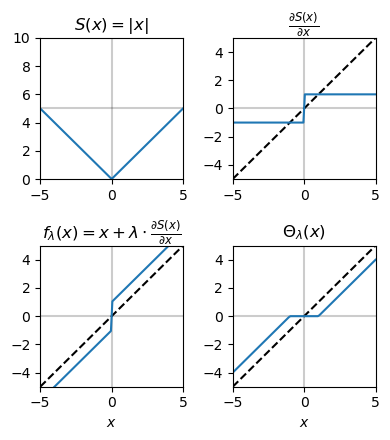

In [3]:
xmin, xmax = -5, 5
x = range(xmin, xmax, length=100)
y = soft_thresholding_func.(x, 1)

figure(figsize=(4,4.5))
subplot(2,2,1)
title(L"$S(x)=|x|$")
plot(x, abs.(x))
xlim(xmin, xmax); ylim(0, 10)
hlines(y=xmax, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=0, ymax=xmax*2, color="k", alpha=0.2)

subplot(2,2,2)
title(L"$\frac{\partial S(x)}{\partial x}$")
plot(x, x, "k--")
plot(x, sign.(x))
xlim(xmin, xmax); ylim(xmin, xmax)
hlines(y=0, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=xmin, ymax=xmax, color="k", alpha=0.2)

subplot(2,2,3)
title(L"$f_\lambda(x)=x+\lambda\cdot\frac{\partial S(x)}{\partial x}$")
plot(x, x, "k--")
plot(x, x + 1*sign.(x))
xlabel(L"$x$")
xlim(-5, 5); ylim(-5, 5)
hlines(y=0, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=xmin, ymax=xmax, color="k", alpha=0.2)

subplot(2,2,4)
title(L"$\Theta_\lambda(x)$")
plot(x, x, "k--")
plot(x, y)
xlabel(L"$x$")
xlim(-5, 5); ylim(-5, 5)
hlines(y=0, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=xmin, ymax=xmax, color="k", alpha=0.2)

tight_layout()

なお、軟判定閾値関数は次の目的関数$C$を最小化する$x$を求めることで導出できる。

$$
C=\frac{1}{2}(y-x)^2+\lambda |x|
$$

ただし、$x, y, \lambda$はスカラー値とする。$|x|$が微分できないが、これは場合分けを考えることで解決する。$x\geq 0$を考えると、(6)式は

$$
C=\frac{1}{2}(y-x)^2+\lambda x = \{x-(y-\lambda)\}^2+\lambda(y-\lambda)
$$

となる。(7)式の最小値を与える$x$は場合分けをして考えると、$y-\lambda\geq0$のとき二次関数の頂点を考えて$x=y-\lambda$となる。 一方で$y-\lambda<0$のときは$x\geq0$において単調増加な関数となるので、最小となるのは$x=0$のときである。同様の議論を$x\leq0$に対しても行うことで (5)式が得られる。

閾値関数としては軟判定閾値関数だけではなく、硬判定閾値関数や$y=x - \text{tanh}(x)$ (Tanhshrink)など様々な関数を用いることができます。

## 11.1.4 重み行列の更新則
$\boldsymbol{r}$が収束したら勾配法により$\Phi$を更新する。

$$
\begin{aligned}
\Delta \phi_i(\boldsymbol{x}) &= -\eta \frac{\partial E}{\partial \Phi}\\
&=\eta\cdot\left[\left([\boldsymbol{I}-\Phi\boldsymbol{r}\right)\boldsymbol{r}^T\right]
\end{aligned}
$$

## 11.1.5 Sparse coding networkの実装
ネットワークは入力層を含め2層の単純な構造である。今回は、入力はランダムに切り出した16×16 (＝256)の画像パッチとし、これを入力層の256個のニューロンが受け取るとする。入力層のニューロンは次層の100個のニューロンに投射するとする。100個のニューロンが入力をSparseに符号化するようにその活動および重み行列を最適化する。

### 画像データの読み込み
データは<http://www.rctn.org/bruno/sparsenet/>からダウンロードできる [^datasets]。`IMAGES_RAW.mat`は10枚の自然画像で、`IMAGES.mat`はそれを白色化したものである。`mat`ファイルの読み込みには[MAT.jl](https://github.com/JuliaIO/MAT.jl)を用いる。

[^datasets]: これはアメリカ北西部で撮影された自然画像であり、[van Hateren's Natural Image Dataset](http://bethgelab.org/datasets/vanhateren/)から取得されたものである。

In [4]:
using MAT
#using PyPlot

In [5]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images_raw = matopen("_static/datasets/IMAGES_RAW.mat")
imgs_raw = read(mat_images_raw, "IMAGESr")

mat_images = matopen("_static/datasets/IMAGES.mat")
imgs = read(mat_images, "IMAGES")

close(mat_images_raw)
close(mat_images)

画像データを描画する。

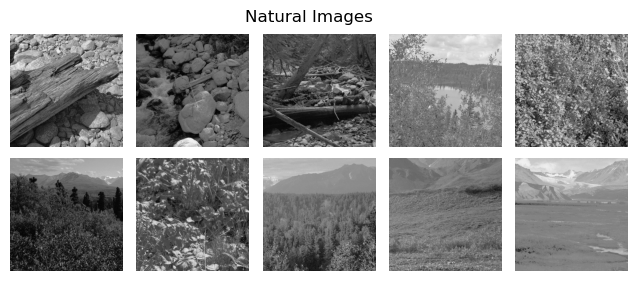

In [6]:
figure(figsize=(8, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i=1:10
    subplot(2, 5, i)
    imshow(imgs_raw[:,:,i], cmap="gray")
    axis("off")
end
suptitle("Natural Images", fontsize=12)
subplots_adjust(top=0.9)  

### モデルの定義
必要なパッケージを読み込む。

In [7]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra
using Random
using Statistics
using ProgressMeter

モデルを定義する。

In [8]:
@kwdef struct OFParameter{FT}
    lr_r::FT = 1e-2 # learning rate of r
    lr_Phi::FT = 1e-2 # learning rate of Phi
    lmda::FT = 5e-3 # regularization parameter
end

@kwdef mutable struct OlshausenField1996Model{FT}
    param::OFParameter = OFParameter{FT}()
    num_inputs::Int32
    num_units::Int32
    batch_size::Int32
    r::Array{FT} = zeros(batch_size, num_units) # activity of neurons
    Phi::Array{FT} = randn(num_inputs, num_units) .* sqrt(1/num_units)
end

パラメータを更新する関数を定義する。

In [9]:
function updateOF!(variable::OlshausenField1996Model, param::OFParameter, inputs::Array, training::Bool)
    @unpack num_inputs, num_units, batch_size, r, Phi = variable
    @unpack lr_r, lr_Phi, lmda = param

    # Updates                
    error = inputs .- r * Phi'
    r_ = r +lr_r .* error * Phi

    r[:, :] = soft_thresholding_func.(r_, lmda)

    if training 
        error = inputs - r * Phi'
        dPhi = error' * r
        Phi[:, :] += lr_Phi * dPhi
    end
    
    return error
end

updateOF! (generic function with 1 method)

行ごとに正規化する関数を定義する。

In [10]:
function normalize_rows(A::Array)
    return A ./ sqrt.(sum(A.^2, dims=1) .+ 1e-8)
end

normalize_rows (generic function with 1 method)

損失関数を定義する。

In [11]:
function calculate_total_error(error, r, lmda)
    recon_error = mean(error.^2)
    sparsity_r = lmda*mean(abs.(r)) 
    return recon_error + sparsity_r
end

calculate_total_error (generic function with 1 method)

シミュレーションを実行する関数を定義する。外側の`for loop`では画像パッチの作成と`r`の初期化を行う。内側の`for loop`では`r`が収束するまで更新を行い、収束したときに重み行列`Phi`を更新する。

In [12]:
function run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps)
    H, W, num_images = size(imgs)
    num_inputs = sz^2

    model = OlshausenField1996Model{Float32}(num_inputs=num_inputs, num_units=num_units, batch_size=batch_size)
    errorarr = zeros(num_iter) # Vector to save errors    
    
    # Run simulation
    @showprogress "Computing..." for iter in 1:num_iter
        # Get the coordinates of the upper left corner of clopping image randomly.
        beginx = rand(1:W-sz, batch_size)
        beginy = rand(1:H-sz, batch_size)

        inputs = zeros(batch_size, num_inputs)  # Input image patches

        # Get images randomly
        for i in 1:batch_size        
            idx = rand(1:num_images)
            img = imgs[:, :, idx]
            clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
            #clop = collect(flatten(img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1]))
            inputs[i, :] = clop .- mean(clop)
        end

        model.r = zeros(batch_size, num_units) # Reset r states
        model.Phi = normalize_rows(model.Phi) # Normalize weights
        # Input image patches until latent variables are converged 
        r_tm1 = zeros(batch_size, num_units)  # set previous r (t minus 1)

        for t in 1:nt_max
            # Update r without update weights 
            error = updateOF!(model, model.param, inputs, false)

            dr = model.r - r_tm1 

            # Compute norm of r
            dr_norm = sqrt(sum(dr.^2)) / sqrt(sum(r_tm1.^2) + 1e-8)
            r_tm1 = copy(model.r) # update r_tm1

            # Check convergence of r, then update weights
            if dr_norm < eps
                error = updateOF!(model, model.param, inputs, true)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.lmda) # Append errors
                break
            end

            # If failure to convergence, break and print error
            if t >= nt_max-1
                print("Error at patch:", iter_, dr_norm)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.lmda) # Append errors
                break
            end
        end
        """
        # Print moving average error
        if iter % 100 == 0
            moving_average_error = mean(errorarr[iter-99:iter])
            println("iter: ", iter, "/", num_iter, ", Moving average error:", moving_average_error)
        end
        """
    end
    return model, errorarr
end

run_simulation (generic function with 1 method)

### シミュレーションの実行

In [13]:
# Simulation constants
num_iter = 500 # number of iterations
nt_max = 1000 # Maximum number of simulation time
batch_size = 250 # Batch size

sz = 16 # image patch size
num_units = 100 # number of neurons (units)
eps = 1e-2 # small value which determines convergence

model, errorarr = run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps)

Computing...  0%|█                                      |  ETA: 0:21:15

Computing...  0%|█                                      |  ETA: 0:12:18

Computing...  1%|█                                      |  ETA: 0:09:02

Computing...  1%|█                                      |  ETA: 0:07:23

Computing...  1%|█                                      |  ETA: 0:06:24

Computing...  1%|█                                      |  ETA: 0:05:46

Computing...  1%|█                                      |  ETA: 0:05:19

Computing...  2%|█                                      |  ETA: 0:04:57

Computing...  2%|█                                      |  ETA: 0:04:40

Computing...  2%|█                                      |  ETA: 0:04:27

Computing...  2%|█                                      |  ETA: 0:04:16

Computing...  2%|█                                      |  ETA: 0:04:06

Computing...  3%|██                                     |  ETA: 0:03:58

Computing...  3%|██                                     |  ETA: 0:03:51

Computing...  3%|██                                     |  ETA: 0:03:45

Computing...  3%|██                                     |  ETA: 0:03:40

Computing...  3%|██                                     |  ETA: 0:03:35

Computing...  4%|██                                     |  ETA: 0:03:31

Computing...  4%|██                                     |  ETA: 0:03:27

Computing...  4%|██                                     |  ETA: 0:03:24

Computing...  4%|██                                     |  ETA: 0:03:20

Computing...  4%|██                                     |  ETA: 0:03:17

Computing...  5%|██                                     |  ETA: 0:03:15

Computing...  5%|██                                     |  ETA: 0:03:12

Computing...  5%|██                                     |  ETA: 0:03:10

Computing...  5%|███                                    |  ETA: 0:03:08

Computing...  5%|███                                    |  ETA: 0:03:05

Computing...  6%|███                                    |  ETA: 0:03:03

Computing...  6%|███                                    |  ETA: 0:03:01

Computing...  6%|███                                    |  ETA: 0:02:59

Computing...  6%|███                                    |  ETA: 0:02:57

Computing...  6%|███                                    |  ETA: 0:02:55

Computing...  7%|███                                    |  ETA: 0:02:54

Computing...  7%|███                                    |  ETA: 0:02:52

Computing...  7%|███                                    |  ETA: 0:02:51

Computing...  7%|███                                    |  ETA: 0:02:49

Computing...  7%|███                                    |  ETA: 0:02:48

Computing...  8%|███                                    |  ETA: 0:02:46

Computing...  8%|████                                   |  ETA: 0:02:45

Computing...  8%|████                                   |  ETA: 0:02:44

Computing...  8%|████                                   |  ETA: 0:02:42

Computing...  8%|████                                   |  ETA: 0:02:41

Computing...  9%|████                                   |  ETA: 0:02:40

Computing...  9%|████                                   |  ETA: 0:02:39

Computing...  9%|████                                   |  ETA: 0:02:38

Computing...  9%|████                                   |  ETA: 0:02:37

Computing...  9%|████                                   |  ETA: 0:02:36

Computing... 10%|████                                   |  ETA: 0:02:35

Computing... 10%|████                                   |  ETA: 0:02:34

Computing... 10%|████                                   |  ETA: 0:02:33

Computing... 10%|████                                   |  ETA: 0:02:32

Computing... 10%|█████                                  |  ETA: 0:02:32

Computing... 11%|█████                                  |  ETA: 0:02:31

Computing... 11%|█████                                  |  ETA: 0:02:30

Computing... 11%|█████                                  |  ETA: 0:02:29

Computing... 11%|█████                                  |  ETA: 0:02:29

Computing... 11%|█████                                  |  ETA: 0:02:28

Computing... 12%|█████                                  |  ETA: 0:02:27

Computing... 12%|█████                                  |  ETA: 0:02:26

Computing... 12%|█████                                  |  ETA: 0:02:26

Computing... 12%|█████                                  |  ETA: 0:02:25

Computing... 12%|█████                                  |  ETA: 0:02:24

Computing... 13%|█████                                  |  ETA: 0:02:24

Computing... 13%|█████                                  |  ETA: 0:02:23

Computing... 13%|██████                                 |  ETA: 0:02:23

Computing... 13%|██████                                 |  ETA: 0:02:22

Computing... 13%|██████                                 |  ETA: 0:02:21

Computing... 14%|██████                                 |  ETA: 0:02:21

Computing... 14%|██████                                 |  ETA: 0:02:20

Computing... 14%|██████                                 |  ETA: 0:02:19

Computing... 14%|██████                                 |  ETA: 0:02:19

Computing... 14%|██████                                 |  ETA: 0:02:18

Computing... 15%|██████                                 |  ETA: 0:02:18

Computing... 15%|██████                                 |  ETA: 0:02:17

Computing... 15%|██████                                 |  ETA: 0:02:17

Computing... 15%|██████                                 |  ETA: 0:02:16

Computing... 15%|███████                                |  ETA: 0:02:15

Computing... 16%|███████                                |  ETA: 0:02:15

Computing... 16%|███████                                |  ETA: 0:02:14

Computing... 16%|███████                                |  ETA: 0:02:14

Computing... 16%|███████                                |  ETA: 0:02:13

Computing... 16%|███████                                |  ETA: 0:02:12

Computing... 17%|███████                                |  ETA: 0:02:12

Computing... 17%|███████                                |  ETA: 0:02:11

Computing... 17%|███████                                |  ETA: 0:02:11

Computing... 17%|███████                                |  ETA: 0:02:10

Computing... 17%|███████                                |  ETA: 0:02:10

Computing... 18%|███████                                |  ETA: 0:02:09

Computing... 18%|███████                                |  ETA: 0:02:09

Computing... 18%|████████                               |  ETA: 0:02:08

Computing... 18%|████████                               |  ETA: 0:02:08

Computing... 18%|████████                               |  ETA: 0:02:07

Computing... 19%|████████                               |  ETA: 0:02:07

Computing... 19%|████████                               |  ETA: 0:02:06

Computing... 19%|████████                               |  ETA: 0:02:06

Computing... 19%|████████                               |  ETA: 0:02:05

Computing... 19%|████████                               |  ETA: 0:02:05

Computing... 20%|████████                               |  ETA: 0:02:04

Computing... 20%|████████                               |  ETA: 0:02:04

Computing... 20%|████████                               |  ETA: 0:02:04

Computing... 20%|████████                               |  ETA: 0:02:03

Computing... 20%|████████                               |  ETA: 0:02:03

Computing... 21%|█████████                              |  ETA: 0:02:02

Computing... 21%|█████████                              |  ETA: 0:02:02

Computing... 21%|█████████                              |  ETA: 0:02:01

Computing... 21%|█████████                              |  ETA: 0:02:01

Computing... 21%|█████████                              |  ETA: 0:02:00

Computing... 22%|█████████                              |  ETA: 0:02:00

Computing... 22%|█████████                              |  ETA: 0:02:00

Computing... 22%|█████████                              |  ETA: 0:01:59

Computing... 22%|█████████                              |  ETA: 0:01:59

Computing... 22%|█████████                              |  ETA: 0:01:58

Computing... 23%|█████████                              |  ETA: 0:01:58

Computing... 23%|█████████                              |  ETA: 0:01:57

Computing... 23%|█████████                              |  ETA: 0:01:57

Computing... 23%|██████████                             |  ETA: 0:01:57

Computing... 23%|██████████                             |  ETA: 0:01:56

Computing... 24%|██████████                             |  ETA: 0:01:56

Computing... 24%|██████████                             |  ETA: 0:01:55

Computing... 24%|██████████                             |  ETA: 0:01:55

Computing... 24%|██████████                             |  ETA: 0:01:55

Computing... 24%|██████████                             |  ETA: 0:01:54

Computing... 25%|██████████                             |  ETA: 0:01:54

Computing... 25%|██████████                             |  ETA: 0:01:53

Computing... 25%|██████████                             |  ETA: 0:01:53

Computing... 25%|██████████                             |  ETA: 0:01:53

Computing... 25%|██████████                             |  ETA: 0:01:52

Computing... 26%|██████████                             |  ETA: 0:01:52

Computing... 26%|███████████                            |  ETA: 0:01:51

Computing... 26%|███████████                            |  ETA: 0:01:51

Computing... 26%|███████████                            |  ETA: 0:01:51

Computing... 26%|███████████                            |  ETA: 0:01:50

Computing... 27%|███████████                            |  ETA: 0:01:50

Computing... 27%|███████████                            |  ETA: 0:01:50

Computing... 27%|███████████                            |  ETA: 0:01:49

Computing... 27%|███████████                            |  ETA: 0:01:49

Computing... 27%|███████████                            |  ETA: 0:01:48

Computing... 28%|███████████                            |  ETA: 0:01:48

Computing... 28%|███████████                            |  ETA: 0:01:48

Computing... 28%|███████████                            |  ETA: 0:01:47

Computing... 28%|███████████                            |  ETA: 0:01:47

Computing... 28%|████████████                           |  ETA: 0:01:47

Computing... 29%|████████████                           |  ETA: 0:01:46

Computing... 29%|████████████                           |  ETA: 0:01:46

Computing... 29%|████████████                           |  ETA: 0:01:46

Computing... 29%|████████████                           |  ETA: 0:01:45

Computing... 29%|████████████                           |  ETA: 0:01:45

Computing... 30%|████████████                           |  ETA: 0:01:44

Computing... 30%|████████████                           |  ETA: 0:01:44

Computing... 30%|████████████                           |  ETA: 0:01:44

Computing... 30%|████████████                           |  ETA: 0:01:43

Computing... 30%|████████████                           |  ETA: 0:01:43

Computing... 31%|████████████                           |  ETA: 0:01:43

Computing... 31%|█████████████                          |  ETA: 0:01:42

Computing... 31%|█████████████                          |  ETA: 0:01:42

Computing... 31%|█████████████                          |  ETA: 0:01:42

Computing... 31%|█████████████                          |  ETA: 0:01:41

Computing... 32%|█████████████                          |  ETA: 0:01:41

Computing... 32%|█████████████                          |  ETA: 0:01:41

Computing... 32%|█████████████                          |  ETA: 0:01:40

Computing... 32%|█████████████                          |  ETA: 0:01:40

Computing... 32%|█████████████                          |  ETA: 0:01:40

Computing... 33%|█████████████                          |  ETA: 0:01:40

Computing... 33%|█████████████                          |  ETA: 0:01:39

Computing... 33%|█████████████                          |  ETA: 0:01:39

Computing... 33%|█████████████                          |  ETA: 0:01:38

Computing... 33%|██████████████                         |  ETA: 0:01:38

Computing... 34%|██████████████                         |  ETA: 0:01:38[39

Computing... 34%|██████████████                         |  ETA: 0:01:37

Computing... 34%|██████████████                         |  ETA: 0:01:37

Computing... 34%|██████████████                         |  ETA: 0:01:37

Computing... 34%|██████████████                         |  ETA: 0:01:36

Computing... 35%|██████████████                         |  ETA: 0:01:36

Computing... 35%|██████████████                         |  ETA: 0:01:36

Computing... 35%|██████████████                         |  ETA: 0:01:35

Computing... 35%|██████████████                         |  ETA: 0:01:35

Computing... 35%|██████████████                         |  ETA: 0:01:35

Computing... 36%|██████████████                         |  ETA: 0:01:34

Computing... 36%|██████████████                         |  ETA: 0:01:34

Computing... 36%|███████████████                        |  ETA: 0:01:34

Computing... 36%|███████████████                        |  ETA: 0:01:33[39

Computing... 36%|███████████████                        |  ETA: 0:01:33

Computing... 37%|███████████████                        |  ETA: 0:01:32

Computing... 37%|███████████████                        |  ETA: 0:01:32

Computing... 37%|███████████████                        |  ETA: 0:01:32

Computing... 37%|███████████████                        |  ETA: 0:01:32

Computing... 37%|███████████████                        |  ETA: 0:01:31

Computing... 38%|███████████████                        |  ETA: 0:01:31

Computing... 38%|███████████████                        |  ETA: 0:01:31

Computing... 38%|███████████████                        |  ETA: 0:01:30

Computing... 38%|███████████████                        |  ETA: 0:01:30

Computing... 38%|███████████████                        |  ETA: 0:01:30

Computing... 39%|████████████████                       |  ETA: 0:01:29

Computing... 39%|████████████████                       |  ETA: 0:01:29

Computing... 39%|████████████████                       |  ETA: 0:01:29

Computing... 39%|████████████████                       |  ETA: 0:01:28

Computing... 39%|████████████████                       |  ETA: 0:01:28

Computing... 40%|████████████████                       |  ETA: 0:01:28

Computing... 40%|████████████████                       |  ETA: 0:01:27

Computing... 40%|████████████████                       |  ETA: 0:01:27

Computing... 40%|████████████████                       |  ETA: 0:01:27

Computing... 40%|████████████████                       |  ETA: 0:01:26

Computing... 41%|████████████████                       |  ETA: 0:01:26

Computing... 41%|████████████████                       |  ETA: 0:01:26

Computing... 41%|████████████████                       |  ETA: 0:01:26

Computing... 41%|█████████████████                      |  ETA: 0:01:25

Computing... 41%|█████████████████                      |  ETA: 0:01:25

Computing... 42%|█████████████████                      |  ETA: 0:01:25

Computing... 42%|█████████████████                      |  ETA: 0:01:24

Computing... 42%|█████████████████                      |  ETA: 0:01:24

Computing... 42%|█████████████████                      |  ETA: 0:01:24

Computing... 42%|█████████████████                      |  ETA: 0:01:23

Computing... 43%|█████████████████                      |  ETA: 0:01:23

Computing... 43%|█████████████████                      |  ETA: 0:01:23

Computing... 43%|█████████████████                      |  ETA: 0:01:22

Computing... 43%|█████████████████                      |  ETA: 0:01:22

Computing... 43%|█████████████████                      |  ETA: 0:01:22

Computing... 44%|██████████████████                     |  ETA: 0:01:21

Computing... 44%|██████████████████                     |  ETA: 0:01:21

Computing... 44%|██████████████████                     |  ETA: 0:01:21

Computing... 44%|██████████████████                     |  ETA: 0:01:20

Computing... 44%|██████████████████                     |  ETA: 0:01:20

Computing... 45%|██████████████████                     |  ETA: 0:01:20

Computing... 45%|██████████████████                     |  ETA: 0:01:20

Computing... 45%|██████████████████                     |  ETA: 0:01:19

Computing... 45%|██████████████████                     |  ETA: 0:01:19

Computing... 45%|██████████████████                     |  ETA: 0:01:19

Computing... 46%|██████████████████                     |  ETA: 0:01:18

Computing... 46%|██████████████████                     |  ETA: 0:01:18

Computing... 46%|██████████████████                     |  ETA: 0:01:18

Computing... 46%|███████████████████                    |  ETA: 0:01:17

Computing... 46%|███████████████████                    |  ETA: 0:01:17

Computing... 47%|███████████████████                    |  ETA: 0:01:17

Computing... 47%|███████████████████                    |  ETA: 0:01:17

Computing... 47%|███████████████████                    |  ETA: 0:01:16

Computing... 47%|███████████████████                    |  ETA: 0:01:16

Computing... 47%|███████████████████                    |  ETA: 0:01:16

Computing... 48%|███████████████████                    |  ETA: 0:01:15

Computing... 48%|███████████████████                    |  ETA: 0:01:15

Computing... 48%|███████████████████                    |  ETA: 0:01:15

Computing... 48%|███████████████████                    |  ETA: 0:01:14

Computing... 48%|███████████████████                    |  ETA: 0:01:14

Computing... 49%|███████████████████                    |  ETA: 0:01:14

Computing... 49%|████████████████████                   |  ETA: 0:01:14

Computing... 49%|████████████████████                   |  ETA: 0:01:13

Computing... 49%|████████████████████                   |  ETA: 0:01:13

Computing... 49%|████████████████████                   |  ETA: 0:01:13

Computing... 50%|████████████████████                   |  ETA: 0:01:12

Computing... 50%|████████████████████                   |  ETA: 0:01:12

Computing... 50%|████████████████████                   |  ETA: 0:01:12

Computing... 50%|████████████████████                   |  ETA: 0:01:11

Computing... 50%|████████████████████                   |  ETA: 0:01:11

Computing... 51%|████████████████████                   |  ETA: 0:01:11

Computing... 51%|████████████████████                   |  ETA: 0:01:10

Computing... 51%|████████████████████                   |  ETA: 0:01:10

Computing... 51%|████████████████████                   |  ETA: 0:01:10

Computing... 51%|█████████████████████                  |  ETA: 0:01:10

Computing... 52%|█████████████████████                  |  ETA: 0:01:09

Computing... 52%|█████████████████████                  |  ETA: 0:01:09

Computing... 52%|█████████████████████                  |  ETA: 0:01:09

Computing... 52%|█████████████████████                  |  ETA: 0:01:08

Computing... 52%|█████████████████████                  |  ETA: 0:01:08

Computing... 53%|█████████████████████                  |  ETA: 0:01:08

Computing... 53%|█████████████████████                  |  ETA: 0:01:07

Computing... 53%|█████████████████████                  |  ETA: 0:01:07

Computing... 53%|█████████████████████                  |  ETA: 0:01:07

Computing... 53%|█████████████████████                  |  ETA: 0:01:07

Computing... 54%|█████████████████████                  |  ETA: 0:01:06

Computing... 54%|█████████████████████                  |  ETA: 0:01:06

Computing... 54%|██████████████████████                 |  ETA: 0:01:06

Computing... 54%|██████████████████████                 |  ETA: 0:01:05

Computing... 54%|██████████████████████                 |  ETA: 0:01:05

Computing... 55%|██████████████████████                 |  ETA: 0:01:05

Computing... 55%|██████████████████████                 |  ETA: 0:01:05

Computing... 55%|██████████████████████                 |  ETA: 0:01:04

Computing... 55%|██████████████████████                 |  ETA: 0:01:04

Computing... 55%|██████████████████████                 |  ETA: 0:01:04

Computing... 56%|██████████████████████                 |  ETA: 0:01:03

Computing... 56%|██████████████████████                 |  ETA: 0:01:03

Computing... 56%|██████████████████████                 |  ETA: 0:01:03

Computing... 56%|██████████████████████                 |  ETA: 0:01:03

Computing... 56%|██████████████████████                 |  ETA: 0:01:02

Computing... 57%|███████████████████████                |  ETA: 0:01:02

Computing... 57%|███████████████████████                |  ETA: 0:01:02

Computing... 57%|███████████████████████                |  ETA: 0:01:01

Computing... 57%|███████████████████████                |  ETA: 0:01:01

Computing... 57%|███████████████████████                |  ETA: 0:01:01

Computing... 58%|███████████████████████                |  ETA: 0:01:00

Computing... 58%|███████████████████████                |  ETA: 0:01:00

Computing... 58%|███████████████████████                |  ETA: 0:01:00

Computing... 58%|███████████████████████                |  ETA: 0:01:00

Computing... 58%|███████████████████████                |  ETA: 0:00:59

Computing... 59%|███████████████████████                |  ETA: 0:00:59

Computing... 59%|███████████████████████                |  ETA: 0:00:59

Computing... 59%|████████████████████████               |  ETA: 0:00:58

Computing... 59%|████████████████████████               |  ETA: 0:00:58

Computing... 59%|████████████████████████               |  ETA: 0:00:58

Computing... 60%|████████████████████████               |  ETA: 0:00:58

Computing... 60%|████████████████████████               |  ETA: 0:00:57

Computing... 60%|████████████████████████               |  ETA: 0:00:57

Computing... 60%|████████████████████████               |  ETA: 0:00:57

Computing... 60%|████████████████████████               |  ETA: 0:00:56

Computing... 61%|████████████████████████               |  ETA: 0:00:56

Computing... 61%|████████████████████████               |  ETA: 0:00:56

Computing... 61%|████████████████████████               |  ETA: 0:00:55

Computing... 61%|████████████████████████               |  ETA: 0:00:55

Computing... 62%|█████████████████████████              |  ETA: 0:00:55

Computing... 62%|█████████████████████████              |  ETA: 0:00:54

Computing... 62%|█████████████████████████              |  ETA: 0:00:54

Computing... 62%|█████████████████████████              |  ETA: 0:00:54

Computing... 62%|█████████████████████████              |  ETA: 0:00:53

Computing... 63%|█████████████████████████              |  ETA: 0:00:53

Computing... 63%|█████████████████████████              |  ETA: 0:00:53

Computing... 63%|█████████████████████████              |  ETA: 0:00:52

Computing... 63%|█████████████████████████              |  ETA: 0:00:52

Computing... 63%|█████████████████████████              |  ETA: 0:00:52

Computing... 64%|█████████████████████████              |  ETA: 0:00:52

Computing... 64%|█████████████████████████              |  ETA: 0:00:51[39

m

Computing... 64%|█████████████████████████              |  ETA: 0:00:51

Computing... 64%|██████████████████████████             |  ETA: 0:00:51

Computing... 64%|██████████████████████████             |  ETA: 0:00:50

Computing... 65%|██████████████████████████             |  ETA: 0:00:50

Computing... 65%|██████████████████████████             |  ETA: 0:00:50

Computing... 65%|██████████████████████████             |  ETA: 0:00:50

Computing... 65%|██████████████████████████             |  ETA: 0:00:49

Computing... 65%|██████████████████████████             |  ETA: 0:00:49

Computing... 66%|██████████████████████████             |  ETA: 0:00:49

Computing... 66%|██████████████████████████             |  ETA: 0:00:48

Computing... 66%|██████████████████████████             |  ETA: 0:00:48

Computing... 66%|██████████████████████████             |  ETA: 0:00:48

Computing... 66%|██████████████████████████             |  ETA: 0:00:48

Computing... 67%|██████████████████████████             |  ETA: 0:00:47

Computing... 67%|███████████████████████████            |  ETA: 0:00:47

Computing... 67%|███████████████████████████            |  ETA: 0:00:47

Computing... 67%|███████████████████████████            |  ETA: 0:00:46

Computing... 67%|███████████████████████████            |  ETA: 0:00:46

Computing... 68%|███████████████████████████            |  ETA: 0:00:46

Computing... 68%|███████████████████████████            |  ETA: 0:00:46

Computing... 68%|███████████████████████████            |  ETA: 0:00:45

Computing... 68%|███████████████████████████            |  ETA: 0:00:45

Computing... 68%|███████████████████████████            |  ETA: 0:00:45

Computing... 69%|███████████████████████████            |  ETA: 0:00:44

Computing... 69%|███████████████████████████            |  ETA: 0:00:44

Computing... 69%|███████████████████████████            |  ETA: 0:00:44

Computing... 69%|███████████████████████████            |  ETA: 0:00:44

Computing... 69%|████████████████████████████           |  ETA: 0:00:43

Computing... 70%|████████████████████████████           |  ETA: 0:00:43

Computing... 70%|████████████████████████████           |  ETA: 0:00:43

Computing... 70%|████████████████████████████           |  ETA: 0:00:42

Computing... 70%|████████████████████████████           |  ETA: 0:00:42

Computing... 70%|████████████████████████████           |  ETA: 0:00:42

Computing... 71%|████████████████████████████           |  ETA: 0:00:41

Computing... 71%|████████████████████████████           |  ETA: 0:00:41

Computing... 71%|████████████████████████████           |  ETA: 0:00:41

Computing... 71%|████████████████████████████           |  ETA: 0:00:41

Computing... 71%|████████████████████████████           |  ETA: 0:00:40

Computing... 72%|████████████████████████████           |  ETA: 0:00:40

Computing... 72%|█████████████████████████████          |  ETA: 0:00:40

Computing... 72%|█████████████████████████████          |  ETA: 0:00:39

Computing... 72%|█████████████████████████████          |  ETA: 0:00:39

Computing... 72%|█████████████████████████████          |  ETA: 0:00:39

Computing... 73%|█████████████████████████████          |  ETA: 0:00:39

Computing... 73%|█████████████████████████████          |  ETA: 0:00:38

Computing... 73%|█████████████████████████████          |  ETA: 0:00:38

Computing... 73%|█████████████████████████████          |  ETA: 0:00:38

Computing... 73%|█████████████████████████████          |  ETA: 0:00:37

Computing... 74%|█████████████████████████████          |  ETA: 0:00:37

Computing... 74%|█████████████████████████████          |  ETA: 0:00:37

Computing... 74%|█████████████████████████████          |  ETA: 0:00:37

Computing... 74%|█████████████████████████████          |  ETA: 0:00:36

Computing... 74%|██████████████████████████████         |  ETA: 0:00:36

Computing... 75%|██████████████████████████████         |  ETA: 0:00:36

Computing... 75%|██████████████████████████████         |  ETA: 0:00:36

Computing... 75%|██████████████████████████████         |  ETA: 0:00:35

Computing... 75%|██████████████████████████████         |  ETA: 0:00:35

Computing... 75%|██████████████████████████████         |  ETA: 0:00:35

Computing... 76%|██████████████████████████████         |  ETA: 0:00:34

Computing... 76%|██████████████████████████████         |  ETA: 0:00:34

Computing... 76%|██████████████████████████████         |  ETA: 0:00:34

Computing... 76%|██████████████████████████████         |  ETA: 0:00:34

Computing... 76%|██████████████████████████████         |  ETA: 0:00:33

Computing... 77%|██████████████████████████████         |  ETA: 0:00:33

Computing... 77%|██████████████████████████████         |  ETA: 0:00:33

Computing... 77%|███████████████████████████████        |  ETA: 0:00:32

Computing... 77%|███████████████████████████████        |  ETA: 0:00:32

Computing... 77%|███████████████████████████████        |  ETA: 0:00:32

Computing... 78%|███████████████████████████████        |  ETA: 0:00:32

Computing... 78%|███████████████████████████████        |  ETA: 0:00:31

Computing... 78%|███████████████████████████████        |  ETA: 0:00:31

Computing... 78%|███████████████████████████████        |  ETA: 0:00:31

Computing... 78%|███████████████████████████████        |  ETA: 0:00:30

Computing... 79%|███████████████████████████████        |  ETA: 0:00:30

Computing... 79%|███████████████████████████████        |  ETA: 0:00:30

Computing... 79%|███████████████████████████████        |  ETA: 0:00:30

Computing... 79%|███████████████████████████████        |  ETA: 0:00:29

Computing... 79%|███████████████████████████████        |  ETA: 0:00:29

Computing... 80%|████████████████████████████████       |  ETA: 0:00:29

Computing... 80%|████████████████████████████████       |  ETA: 0:00:28

Computing... 80%|████████████████████████████████       |  ETA: 0:00:28

Computing... 80%|████████████████████████████████       |  ETA: 0:00:28

Computing... 80%|████████████████████████████████       |  ETA: 0:00:28

Computing... 81%|████████████████████████████████       |  ETA: 0:00:27

Computing... 81%|████████████████████████████████       |  ETA: 0:00:27

Computing... 81%|████████████████████████████████       |  ETA: 0:00:27

Computing... 81%|████████████████████████████████       |  ETA: 0:00:26

Computing... 81%|████████████████████████████████       |  ETA: 0:00:26

Computing... 82%|████████████████████████████████       |  ETA: 0:00:26

Computing... 82%|████████████████████████████████       |  ETA: 0:00:26

Computing... 82%|████████████████████████████████       |  ETA: 0:00:25

Computing... 82%|█████████████████████████████████      |  ETA: 0:00:25

Computing... 82%|█████████████████████████████████      |  ETA: 0:00:25

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:23

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:23

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:23

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:22

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:22

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:22

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:21

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:21

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:21

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:19

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:19

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:19

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:19

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:18

Computing... 87%|███████████████████████████████████    |  ETA: 0:00:18

Computing... 87%|███████████████████████████████████    |  ETA: 0:00:18

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:16

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:16

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:16

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:15

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:15

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:15

Computing... 90%|███████████████████████████████████    |  ETA: 0:00:15

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:14

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:14

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:14

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:11

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:11

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:11

Computing... 92%|█████████████████████████████████████  |  ETA: 0:00:11[3

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 95%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 95%|█████████████████████████████████████  |  ETA: 0:00:07

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:07

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:07

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:06[39

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing...100%|███████████████████████████████████████|  ETA: 0:00:01

Computing...100%|███████████████████████████████████████|  ETA: 0:00:00

Computing...100%|███████████████████████████████████████| Time: 0:02:19


(OlshausenField1996Model{Float32}(OFParameter{Float32}(0.01f0, 0.01f0, 0.005f0), 256, 100, 250, Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … -0.2392792 0.0; 0.0 0.0 … 0.0 0.0], Float32[-0.0068171658 -0.017265145 … -0.0001582715 -0.01947099; -0.007871051 -0.022296097 … 0.020305827 -0.014849793; … ; -0.041804258 -0.03698982 … 0.012746845 -0.024280902; -0.04328692 -0.01961664 … 0.0021332083 0.010294154]), [0.0775364829567312, 0.07101704704982446, 0.06608721739858092, 0.06770301001044944, 0.07053356331524631, 0.06327351797024416, 0.05645153839051058, 0.0704818319898473, 0.06271819957428608, 0.05863544665352008  …  0.046389222265095835, 0.04329260874937741, 0.04573448466673223, 0.0481387016929523, 0.04652197108276113, 0.05550770512834161, 0.04628080266751588, 0.04703599830796455, 0.046513635434028436, 0.045012238916295])

### 訓練中の損失の描画
訓練中の損失の変化を描画してみよう。損失が低下し、学習が進行したことが分かる。

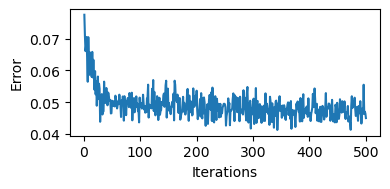

In [14]:
# Plot error
figure(figsize=(4, 2))
ylabel("Error")
xlabel("Iterations")
plot(1:num_iter, errorarr)
tight_layout()

### 重み行列 (受容野)の描画
学習後の重み行列 `Phi` ($\Phi$)を可視化してみよう。

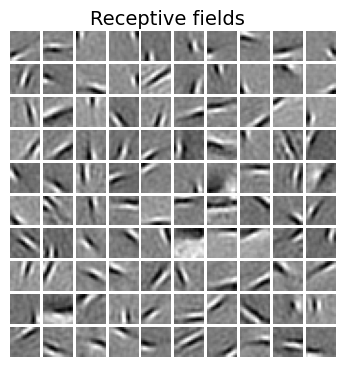

In [15]:
# Plot Receptive fields
figure(figsize=(4.2, 4))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:num_units
    subplot(10, 10, i)
    imshow(reshape(model.Phi[:, i], (sz, sz)), cmap="gray")
    axis("off")
end
suptitle("Receptive fields", fontsize=14)
subplots_adjust(top=0.925)

白色が**ON領域**(興奮)、黒色が**OFF領域**(抑制)を表す。Gaborフィルタ様の局所受容野が得られており、これは一次視覚野(V1)における単純型細胞(simple cells)の受容野に類似している。

```{admonition} 論文以外の参考資料
- Bruno Olshausen: “Sparse coding in brains and machines”([Stanford talks](https://talks.stanford.edu/bruno-olshausen-sparse-coding-in-brains-and-machines/)), [Slide](http://www.rctn.org/bruno/public/Simons-sparse-coding.pdf)
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/sparse-coding-LCA.pdf>
- <https://redwood.berkeley.edu/wp-content/uploads/2018/08/Dylan-lca_overcompleteness_09-27-2018.pdf>
```